# Part 1: Ingestion and Wrangling of CE Data

#### Concepts Covered
Part 1 demonstrates how to begin the data pipeline with electronic data ingestion, use preprocessing techniques to encode a target variable, aggregate data to create features, use visual tools to assess the quality of the data, and store data in a SQLite table.

#### Overview
The target and features will come from the [Consumer Expenditure (CE) Interview survey](https://www.bls.gov/cex/pumd_data.htm), specifically the FMLI and the MEMI files. The FMLI file contains data about the CE household (family) for each survey quarter and the MEMI file contains information about each member of the household. All of the variables included on the files with descriptions can be found on the [CE data dictionary](https://www.bls.gov/cex/pumd/ce_pumd_interview_diary_dictionary.xlsx).

#### Libraries

In [1]:
import io
import joblib
import pandas as pd
import requests
from sklearn import preprocessing
import sqlite3
import zipfile

%matplotlib inline

### Ingestion

- Download CE Data.
- Extract files and output to DB table.

#### Download CE Data

In [2]:
response = requests.get("https://www.bls.gov/cex/pumd/data/comma/intrvw18.zip")

The CE program provides the data as a ZIP file, which can be read using the Zipfile library and the IO library. Specifically, the Zipfile library can read the content of the response object as bytes. Reference from [Stack Overflow](https://stackoverflow.com/questions/9419162/download-returned-zip-file-from-url)

In [3]:
z = zipfile.ZipFile(io.BytesIO(response.content))

#### Extraction and Output

Below are two options for outputting the data:
1. Use the Zipfile libraries `extractall` method to extract the files, which looks identical to a manual extraction of the data.
2. However, to keep with Write One Read Many (WORM) methodology, it is important to consider a more secure storage process.

*Zipfile Extraction*

Pass the file path as an argument to the `extractall` method.
```python
z.extractall("../data")
```

*SQLite Database Table*

Print table names using the `namelist` method to see the naming conventions of the FMLI and MEMI tables for each calendar quarter.
```python
z.namelist()
```
I am going to limit the analysis to one quarter of households from the CE Interview, needing only two tables, the **fmli182.csv, memi182.csv**.

In [4]:
tables = ['intrvw18/fmli182.csv', 'intrvw18/memi182.csv']

for table in tables:
    table_name = table.split('/')[1].split('.')[0]
    print(table_name)

fmli182
memi182


In [5]:
conn = sqlite3.connect('../data/ce_intrvw_data.db')
c = conn.cursor()

for table in tables:
    table_name = table.split('/')[1].split('.')[0]
    
    intrvw = pd.read_csv(z.open(table))

    c.execute("drop table if exists {}".format(table_name))

    intrvw.to_sql(table_name, conn)

conn.commit()
conn.close()

### Wrangling

- Categorizing CE income levels for classification models.
- Aggregating hours worked by all members.
- Output final table to DB.

#### Describe, Classify, Encode Income

*Describe*

The income variable is an integer that represents the "total amount of family income before taxes, after imputation". This means that missing values from data collection have already been populated where appropriate.

Let's describe the income variable with a boxplot. From the boxplot, we can see that there are income values that are below zero. An investigation shows that there are four households with negative income. Additional investigation shows that these are not errors, but reflect total losses due to losses in rental income, or self-proprietorship.

In [6]:
conn = sqlite3.connect('../data/ce_intrvw_data.db')

fmli_df = pd.read_sql('''select * from fmli182''', conn)
memi_df = pd.read_sql('''select * from memi182''', conn)

conn.close()

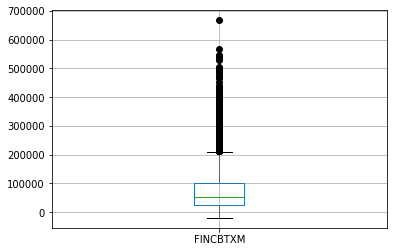

In [7]:
fmli_df.boxplot(column='FINCBTXM', flierprops=dict(markerfacecolor='black'))

*Classify*

Income variable is an integer, so first we must categorize the income as either at least or below 70k.

Alternatively,
```python
lim = 70000

fmli_df['income_class'] = np.where(fmli_df['FINCBTXM'] >= lim, '>=70k', '<70k')
```
or
```python
def income_class(row, lim):
    if np.isnan(row['FINCBTXM']) == True:
        inc_class = np.nan()
    else:
        if row['FINCBTXM'] >= 70000:
            inc_class = '>=70k'
        else:
            inc_class = '<70k'
        
    return inc_class

fmli_df['income_class'] = fmli_df.apply(income_class, axis=1, args=(70000,))
```

In [8]:
lim = 70000

fmli_df.loc[fmli_df['FINCBTXM'] >= lim, 'income_class'] = ">=70k"
fmli_df.loc[fmli_df['FINCBTXM'] < lim, 'income_class'] = "<70k"

A bar chart shows that there is a slight imbalance of our target, but is not an immediate concern. Any imbalance in this case would make it harder for our model to accurately learn and identify households with greater than 70k.

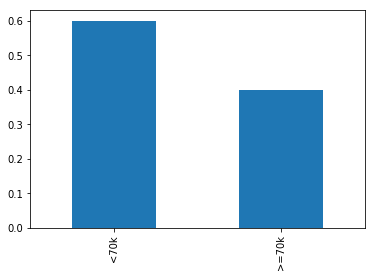

In [9]:
fmli_df['income_class'].value_counts(normalize=True).plot(kind='bar')

*Label Encoding*

In [10]:
le = preprocessing.LabelEncoder()

ic_fit = le.fit(fmli_df['income_class'])

print(ic_fit.classes_)

['<70k' '>=70k']


In [11]:
fmli_df['inc_class_encode'] = ic_fit.transform(fmli_df['income_class'])

As part the pipeline process output any label encoding parameters.

In [12]:
joblib.dump(ic_fit, '../model/income-encoding-fit.sav')

['../model/income-encoding-fit.sav']

#### Aggregate Hours Worked

Aggregate the number of hours worked by members of the household from the MEMI dataframe and merge the results back to the FMLI dataset.

Alternatively,
```python
memi_agg = memi_df.groupby(by=['NEWID'], as_index=False).agg({'INC_HRSQ':'sum'})

wng_df = fmli_df.merge(memi_agg, how='left', on='NEWID')
```

In [13]:
hh_hrs_wrkd = memi_df.groupby(by='NEWID', as_index=False)['INC_HRSQ'].sum()

In [14]:
wng_df = fmli_df.merge(hh_hrs_wrkd, how='left', on='NEWID')

#### Output

In [15]:
table_name = 'final_family_data'

conn = sqlite3.connect('../data/ce_intrvw_data.db')
c = conn.cursor()

c.execute("drop table if exists {}".format(table_name))

wng_df.to_sql(table_name, conn)

conn.commit()
conn.close()